# Introduction

In this tutorial, you will learn how to develop the Siegler Addition model in the Stan programming language. The model is similar to the model developed for the Julia language. The primary difference is the mismatch penalty function, as explained below. You may change the mismatch penalty function by modifying the source code located at `../Stan_Utilities/ACTR_Functions.stan`. The description of the model is repoduced below. Readers who are familar with the model may skip to pertinent sections. 

# Siegler Addition Task

The Siegler addition task is based on a study of childrens' arithmatic ability conducted by Siegler (1984). In the task, children are asked to sum two verbally presented numbers (e.g. 2 + 2), and provide the solution verbally. If the participant does not know the solution, he or she responds "I don't know".  Each block consists of the following problems:

- 1 + 1
- 1 + 2
- 1 + 3
- 2 + 2
- 2 + 3 
- 3 + 3

The block is repeated five times in the present simulation.


# Siegler Addition Model

## Overview

On each trial, the Siegler addition model proceeds through a deterministic chain of production rules that build the problem representation in the imaginal buffer, retrieve the answer, and respond. For each number, the model fires a production rule that listens to the number, retrieves the number from declarative memory, and adds the number to a problem representation chunk in the imaginal buffer. The resulting chunk is used as a retrieval request in the next production rule to obtain the answer from declarative memory. When the next production rule fires, it "harvests" the answer, which entails assigning the answer to a sum slot in the problem representation chunk. Finally, the model fires a production rule to vocalize the answer and merge the problem representation into declarative memory.


## Declarative memory

Declarative memory $M$ is populated with 35 chunks representing addition facts. As an example, consider the chunk $m$:

\begin{align}
\mathbf{c}_m = \{\rm (addend1,2),(addend2,2), (sum,4)\}
\end{align}

Each chunk contains the following three slots: $Q = \{\textrm{addend1},\textrm{addend2}, \textrm{sum}\}$ .The full set of 35 addition facts is generated by permuting integers ranging from 0 to 5 for addend1 and addend2, such that the sum is less 10. Formally, this set is defined as:

\begin{align}
M = \{ \forall_{i,j} \rm [(addend1, j), (addend2, i), (sum, i + j)] : i,j \in \{0,1,\dots 5\}, i + j < 10  \}
\end{align}



## Retrieval Request

The details of the problem are encoded through the aural module where they are transferred and stored in a chunk $\mathbf{c}_s$ located in the imaginal buffer. A retrieval request on trial $i$ is formed from the slots in $\mathbf{c}_s$, which is defined as

\begin{align}
\mathbf{r}_i = \{(\rm addend1, c_s(addend1), (\rm addend2, c_s(addend2) \}
\end{align}

where $Q_r = \{\rm addend1, addend2\}$ is the set of slots for $\mathbf{r}_i$. 

## Activation

Activation for chunk $\mathbf{c}_m$ is defined as:

\begin{align}
a_m = \textrm{blc}_m + \rho_m + \epsilon_m
\end{align}

where $\textrm{blc}_m$ represents degree of prior practice, $\rho_m$ is partial matching activation and $\epsilon \sim \rm Normal(0,s)$. Unlike previous models, blc is indexed by $m$ to reflect the fact that its value depends on the chunk. The rationale for allowing blc to vary as function of $m$ is due to the fact that children have more practice with addition problems in which the sum is less than five, and thus, perform better with these problems. Based on this fact, we can define blc with the following piecewise equation:

\begin{align}\label{eq:penalty_activation_siegler}
\textrm{blc}_m  = \begin{cases}
    .65 & \text{if } c_m(\rm sum) < 5 \\
    0 & \text{otherwise} \\
  \end{cases}\
\end{align}


The model uses the following mismatch penalty function

\begin{equation}\label{eq:penalty_function}
\rho_m = -\delta  \sum_{q \in Q_r} I\left(r(q),  c_{m}(q)\right).
\end{equation}

where $Q_r = \{\textrm{object},\textrm{attribute}\}$ is the set of slots in the retrieval request, the mismatch penalty parameter $\delta$ controls the steepness of the dissimilarity gradient, and $I$ is an indicator function: 

$$ I(x,y) =
  \begin{cases}
    1      & x \neq y\\
    0  & x = y
  \end{cases}
$$

Thus, in the present model, mean activation $\mu_m$ of chunk $m$ assumes one of three values: blc in the case of a match, blc $-\delta$ in the case of a mismatch, or $\tau$ in the case of a retrieval failure.


## Response Mapping

Due to the partial matching mechanism, a given response could be associated with one of several possible chunks. For example, the response $y = 4$ could have resulted from retrieving any chunk that represents the following addition facts:
- $2+2$
- $1+3$
- $3+1$ 
- $4+0$
- $0+4$

In order to account for this in the likelihood function, we define the set $R_i$, which consists of all possible chunks associated with response $y_i$ on trial $i$. Formally, this is defined as:

\begin{align*}
R_i = \{\mathbf{c}_m \in M : c_m(\rm sum) = \textrm{y_i} \} \textrm{ for } y_i \neq \emptyset
\end{align*}


with a response indicating that the sum is unknown ($y_i =\emptyset$) when no chunk is retrieved. 

## Likelihood Function

Let $y_i \in \{1,2,\dots,\emptyset\}$ by the response on trial $i$, where $\emptyset$ represents a retrieval failure response. 

\begin{align}
     \Pr(Y_i = y_i \mid \delta ; \mathbf{r}_i) = \frac{\sum_{\mathbf{c}_m \in R_i} e^{\frac{\mu_m}{\sigma}}}{\sum_{\mathbf{c}_k \in M} e^{\frac{\mu_k}{\sigma}} + e^{\frac{\mu_{m^\prime}}{\sigma}}}
\end{align}

For responses, $\mathbf{Y} = \{y_1,y_2,\dots,y_{N_i}\}$ the likelihood function is defined as

\begin{align}
\mathcal{L}(Y|\Theta) = \prod_{i=1}^N \Pr(Y_i = y_i \mid \delta ; \mathbf{r}_i)
\end{align}

## Assumptions

The following is a summary of the model's assumptions:

1. Retrieval failures are possible
2. Retrieval probabilities are independent
3. No learning occurs
4. Activation is a decreasing function of the difference between the slot values of a chunk and and the slot values of the retrieval request
5. Errors are due to retrieving the wrong information rather than encoding the information incorrectly

# Generate Data

In the code block below,  we will define a function to generate simulated data from the model. The `simulate` function accepts the following arguments:

- stimuli: a `NamedTuple` of addition problems. 
- parms: a `NamedTuple` of fixed parameters
- args...: list of keyword arguments for estimated parameters
-$\delta$: mismatch penalty parameter

In the annotated code below, memory chunks are populated and added to the declarative memory object. The for loop iterates through each addition problem. On each iteration, the current addition problem is used as a retrieval request to generate a distribution of retrieval probabilities. Next, an index is sampled from the distribution representing the retrieved answer.  

In [117]:
# set the working directory to the directory in which this file is contained
cd(@__DIR__)
# load the package manager
using Pkg
# activate the project environment
Pkg.activate("../../../")
# load the required packages
using CmdStan, Distributions, Random, StatsPlots, ACTRModels, CSV, DataFrames, MCMCChains
include("Siegler_Model_Choice.jl")
include("../../../Utilities/Utilities.jl")
# project directory is current directory
proj_dir = pwd()
# rng seed
seed = 558
Random.seed!(seed)

  Activating environment at `~/.julia/dev/ACTRTutorial/Project.toml`


MersenneTwister(558)

In [118]:
function simulate(stimuli, parms; args...)
    # populate memory with addition facts
    chunks = populate_memory()
    # set blc parameters for each chunk
    set_baselevels!(chunks)
    # add chunks to declarative memory
    memory = Declarative(;memory=chunks)
    # add declarative memory to ACTR object
    actr = ACTR(;declarative=memory, parms..., args...)
    # randomize the stimuli
    shuffle!(stimuli)
    N = length(stimuli)
    data = Array{NamedTuple,1}(undef, N)
    for (i,s) in enumerate(stimuli)
        # retrieval probabilities θs given request s
        Θs,r_chunks = retrieval_probs(actr; s...)
        # select chunk index from multinomial distribution
        idx = sample(1:length(Θs), weights(Θs))
        if idx == length(Θs)
            # retrieval failure coded as -100
            data[i] = (s...,resp = -100)
        else
            # record answer based on retrieved chunk
            data[i] = (s...,resp = r_chunks[idx].slots.sum)
        end
    end
    return data
end

simulate (generic function with 1 method)

The code block below generates 5 blocks of data using parameters $\delta = 2.5$, $\tau = -.45$, $s=.5$. The data for each trial is a `NamedTuple` consisting of 

- num1: the first addend of the problem
- num2: the second addedn of the problem
- resp: the response where -100 indicates "I don't know" for a retrieval failure
- N: the number of instances of a specific problem-response combination

In order to improve performance, the code creates a vector of unique data points with counts using the function `unique_data`. Using counts of unique data reduces the time complexity of the main loop from $O(N)$ to $O(1)$. As shown below, this reduces the size of the data from 30 to 15. 

In [119]:
# mismatch penalty
δ = 2.5
# retrieval threshold
τ = -0.45
# logistic scalar 
s = 0.5
parms = (mmp = true,noise = true)
stimuli = [(num1 = 1,num2 = 1), (num1 = 1,num2 = 2), (num1 = 1,num2 = 3), (num1 = 2,num2 = 2),
    (num1 = 2,num2 = 3), (num1 = 3,num2 = 3)]
temp = mapreduce(x -> simulate(stimuli, parms; δ, τ, s), vcat, 1:5)
# get unique data points with counts to improve efficiency
data = unique_data(temp)
data = vcat(data...)
data[1]

(num1 = 1, num2 = 2, resp = 3, N = 5)

In the following two code blocks, the relevant inputs for Stan and defined. We will begin by defining the data that will be passed to Stan. The data consists of the number of observations `n_obs`, the number of duplicate choices, `choice_reps`, and the observed choices, `choice`. 

In [130]:
n_obs = length(data)
choice_reps = map(x->x.N, data)
choice = map(x->x.resp, data);

The other set of inputs consist of matrices of slots and values for declarative memory and the stimuli. Slot are converted to numerical indices: slot 1 represents the slot for the first addend, slot 2 represents the slot for the second addend, and slot 3 represents the slot for the sum.

In [131]:
chunks = populate_memory()
n_chunks = length(chunks)
# slots indexed numerically 1,2,3
memory_slots = repeat([1:3;]', outer=n_chunks)
# convert chunks to a matrix with chunks as rows and addend1, addend2 and addend3 as columns
memory_values = [[values(c.slots)...]  for c in chunks]
memory_values = hcat(memory_values...)'
# convert chunks to a matrix with chunks as rows and addend1 and addend2 as columns
stimuli_values = [[d.num1, d.num2] for d in data]
stimuli_values = hcat(stimuli_values...)'
# slots indexed numerically 1,2,3
stimuli_slots = repeat([1:2;]', outer=n_obs)

12×2 Matrix{Int64}:
 1  2
 1  2
 1  2
 1  2
 1  2
 1  2
 1  2
 1  2
 1  2
 1  2
 1  2
 1  2

The data and matrices for stimuli and declarative memory are bundled in a `Dictionary`, which is passed to Stan.

In [132]:
stan_input = Dict("mp"=>1, "bll"=>0,"sa"=>0, "n_obs"=>n_obs,
  "memory_slots"=>memory_slots, "memory_values"=>memory_values, "n_slots"=>3, 
  "stimuli_slots"=>stimuli_slots,"stimuli_values"=>stimuli_values, "n_chunks"=>n_chunks,
  "choice"=>choice, "choice_reps"=>choice_reps)

Dict{String, Any} with 12 entries:
  "n_obs"          => 12
  "memory_slots"   => [1 2 3; 1 2 3; … ; 1 2 3; 1 2 3]
  "n_slots"        => 3
  "choice"         => [3, 3, 6, 4, 1, 5, 2, 2, 4, -100, -100, -100]
  "bll"            => 0
  "stimuli_slots"  => [1 2; 1 2; … ; 1 2; 1 2]
  "mp"             => 1
  "choice_reps"    => [5, 1, 3, 4, 1, 5, 1, 4, 2, 2, 1, 1]
  "stimuli_values" => [1 2; 1 1; … ; 2 2; 1 3]
  "memory_values"  => [0 0 0; 0 1 1; … ; 5 3 8; 5 4 9]
  "sa"             => 0
  "n_chunks"       => 35

## Define Model
The following summaries the prior distributions and the likelihood. 

\begin{align}
\delta \sim \textrm{Normal}(2.5,1) 
\end{align}

\begin{align}
\tau \sim \textrm{Normal}(-.45,1)
\end{align}

\begin{align}
 s \sim \textrm{TNormal}(.5,.5)_{0}^{\infty}
\end{align}

\begin{align}
 \theta_i = \Pr(Y_i = y_i| \delta, \tau, s; \mathbf{r}_i)
\end{align}


\begin{align}
y_i \sim \textrm{Bernoulli}(\theta_i)
\end{align}


## Data Block

As shown below, the data block contains variables that match the entries in the `stan_input` dictionary. Three types of variables are included in the data block: variables for the data, variables representing chunks in declarative memory, and fixed parameters and settings. 

## Parameter Block 

Three parameters are declared in the parameter block: `tau`, `delta` and `s`. Note that `s` is restricted to non-negative values because it controls the level of activation noise. 

## Model Block

Six local variables are declared at the top of the model block. The values of these parameters can be disregarded because they are not used in the current model. However, they are required inputs into the various ACT-R functions, and thus must be declared. 

The second group of statements is for the prior distributions of delta, tau and s. The log likelihood calculations are performed in the for loop at the bottom of the model block. Inside the for loop, the custom function `computeLL` is called, which returns the log likelihood of a given observation and adds it to the `target` variable, which accumulates the log likelihoods. 

## Function Block 

Two functions are defined in the functon block. The function `adjust_base_levels` adds .65 to the activation of chunks with a sum less than 5. Most of the heavy lifting for computing the likelihood is performed in `computeLL`. A series of local variables are declared at the top of the function. Several variables, such as `imaginal_slots` are required for the ACT-R functions but are not used in this particular model. Some of the relevant variables are:

* `activations`: a vector that holds activation values associated with each chunk and the retrieval threshold.
* `prob`: the likelihood of the current choice.
* `response_slots`: a vector of slots associated with the response (e.g. 3 corresponding to the sum slot)
* `response_values`: a vector of values associated with the response (e.g. the variable `choice` passed to `computeLL`
* `request_result`: a matrix containing slots and values for the result of the retrieval request
* `result_slots`: a matrix of slots for the result of the retrieval request
* `result_values`: a matrix of values for the result of the retrieval request

The first group of commands returns the results of the retrieval request. In the present case, the result of the retrieval request is the slot matrix and value matrix for all chunks because partial matching is enabled (i.e. `mp=1`). The second group of commands computes the activation values associated with the result of the retrieval request. Finally, the last group of commands computes the log likelihood of the response. If the response is a retrieval failure (e.g. choice = -100), a seperate computation is performed. For all other cases, the marginal probability is computed. For example, if the response was `choice`= 3, prob is the sum of the probability of retrieving any chunk whose sum slot is 3 (i.e., 1+2, 2+1, 0+3, etc.). The log of prob is multiplied by the number of duplicates, which improves efficency by computing the activations only once.  

In [123]:
Model = "functions {
    #include ../Stan_Utilities/ACTR_Functions.stan

    // adjust base level activations so that chunks with sum < 5 have higher activation
    row_vector adjust_base_levels(row_vector activations, matrix result_values){
      row_vector[num_elements(activations)] new_activations;
      for(r in 1:rows(result_values)){
        new_activations[r] = activations[r];
        if(result_values[r,3] < 5){
          new_activations[r] += .65;
        }
      }
      return new_activations;
    }

    real computeLL(real d, real blc, real delta, real gamma, int k, real L, int N, real s, real tau, int sa, int mp, int bll,
      int n_chunks, int n_slots, matrix memory_slots, matrix memory_values, row_vector stimulus_slots, row_vector stimulus_values, int choice,
      int choice_rep){
      row_vector[n_slots] imaginal_slots;
      row_vector[n_slots] imaginal_values;
      row_vector[n_chunks+1] activations; // n_chunks + threshold
      row_vector[1] response_slots;
      row_vector[1] response_values;
      // slots: request_result[1,1]
      // values: request_result[1,2]
      // number of chunks: request_result[1,3][1,1]
      matrix[n_chunks,n_slots] request_result[1,3];
      matrix[n_chunks,n_slots] result_slots;
      matrix[n_chunks,n_slots] result_values;
      real lags[1];
      real denoms[n_slots];
      int n_results;
      real prob;

      // Return chunks that match retrieval request (stimulus_slots, stimulus_values). If mp = 1,
      // as in the current case, all chunk slots and values are returned
      request_result = request_chunks(stimulus_slots, stimulus_values, memory_slots, memory_values, mp);
      result_slots = request_result[1,1];
      result_values = request_result[1,2];
      
      n_results = to_int(request_result[1,3][1,1]);
      // compute activation for the result of the retrieval request
      activations = compute_all_activations(blc, d, delta, gamma, tau, k, L, N, lags, sa, mp, bll, result_slots, 
        result_values, stimulus_slots, stimulus_values, n_results, n_chunks, imaginal_slots, imaginal_values, denoms);
      // adjust base level activations so that chunks with sum < 5 have higher activation
      activations = adjust_base_levels(activations, result_values);

      // log likelihood for retrieval failure
      if(choice == -100){
        prob = compute_retrieval_prob(activations, s, tau, n_chunks, n_results + 1);
        return choice_rep * log(prob);
      }
      // third slot index corresponds to sum
      response_slots[1] = 3;
      // slot-value is the sum or given response
      response_values[1] = choice;
      // computes the marginal probability of the response. If choice = 3, then the probability of retrieving 1 + 2, plus
      // the probability of retrieving 2 + 1, and so on...
      prob = marginal_retrieval_prob(activations, s, tau, result_slots, result_values, response_slots, 
        response_values, n_results);
      // compute log probability and multiply by the number of times this response was given to the stimulus
      return choice_rep * log(prob);
    }
}

data {
  int<lower=1> n_obs;                // number of observations
  int<lower=-100> choice[n_obs];     // response indices
  int choice_reps[n_obs];            // number of times response was made
  int<lower=1> n_slots;
  int<lower=1> n_chunks;
  matrix[n_obs,2] stimuli_slots;     //num1,num2
  matrix[n_obs,2] stimuli_values;    //1,2 etc
  matrix[n_chunks,3] memory_values;  //num1,num2,sum
  matrix[n_chunks,3] memory_slots;   //1,2,3 etc
  int<lower=0,upper=1> mp;           // mismatch penality on
  int<lower=0,upper=1> bll;          // baselevel learning on
  int<lower=0,upper=1> sa;           // spreading activation on
}

parameters {
  real delta;                   // mismatch penality
  real tau;                     // retrieval threshold
  real<lower=0> s;              // logistic scale
}

model {
    // all parameters declared here are not used by the model, but must be initialized
    // and passed to functions 

    // decay
    real d;
    // baselevel activation parameter
    real blc;
    // number of uses tracks
    int k;
    // chunk life time
    real L;
    // number of uses of chunk
    int N;
    // spreading activation parameter 
    real gamma;

    d = 0.0;
    gamma = 0.0;
    blc = 0.0;
    k = 1;
    L = 0;
    N = 0;


    delta ~ normal(2.5, 1);       // prior for base level constant
    tau ~ normal(-.45, .5);            // prior for retrieval threshold
    s ~ normal(.5, .5);              // prior for logistic scale

    // loop over data and compute log likelihood of each response
    for(trial in 1:n_obs){
      target += computeLL(d, blc, delta, gamma, k, L, N, s, tau, sa, mp, bll, n_chunks, n_slots,
         memory_slots, memory_values, stimuli_slots[trial,:], stimuli_values[trial,:], choice[trial], 
         choice_reps[trial]);
    }
}
";

## Estimate Parameters

In the following code, we will run four MCMC chains with the NUTS sample for 2,000 iterations and omit the first 1,000 warmup samples. 

In [124]:
# number of chains
n_chains = 4
stanmodel = Stanmodel(Sample(save_warmup=false, num_warmup=1000,
  num_samples=1000, thin=1), nchains=n_chains, name="Siegler_Choice_Model", model=Model,
  printsummary=false, output_format=:mcmcchains, random = CmdStan.Random(seed))
# estimate the parameters
rc, chain, cnames = stan(stanmodel, stan_input, proj_dir)
chain = replacenames(chain, Dict(:tau=>:τ, :delta=>:δ))

Chains MCMC chain (1000×10×4 Array{Float64, 3}):

Iterations        = 1001:2000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = δ, τ, s
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           δ    3.0298    0.6879     0.0109    0.0197   1279.4266    1.0002
           τ   -0.6994    0.3231     0.0051    0.0086   1643.5161    1.0011
           s    0.5097    0.1280     0.0020    0.0036   1300.9935    1.0004

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           δ    1.8316    2.5278    2.9825    3.4961    4.4620
           τ   -1.3602   -0.9041   -0.6854   -0.4700   -0.1366
           s    0.2949    0.4169    0.4985 

## Results

### Diagnostics

The first panel for each plot shows good mixing between the four chains. Furthermore, $\hat{r} \approx 1$ for each parameter, indicating that the chains converged.  In the second panel for each plot, the auto-correlation between successive samples drops rapidly after a lag of about 5, indicating a high effective sample size.

### Posterior Distributions 

The posterior distributions in the third panel of each plot encompass the data generating values ($\delta = 2.5$, $\tau = -.45$, $s = .5$), indicating acceptable parameter recovery. Although the posterior distributions are somewhat wide, their standard deviations are smaller compared to the standard deviations of the prior distributions. 



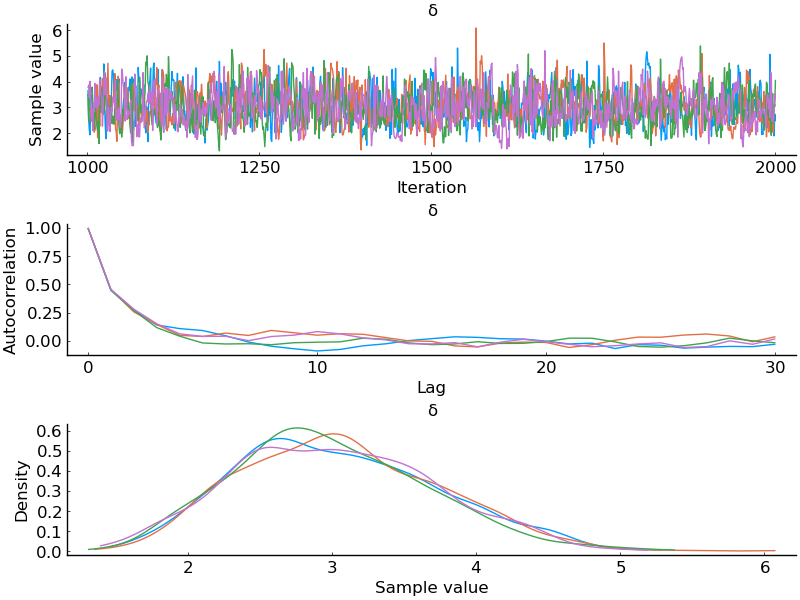

In [125]:
pyplot()
font_size = 12
ch = group(chain, :δ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(800,600))

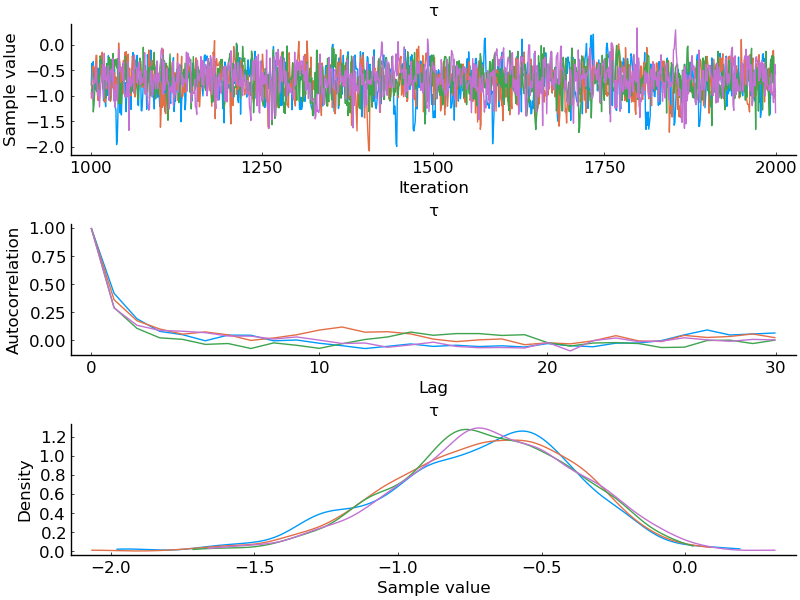

In [126]:
ch = group(chain, :τ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(800,600))

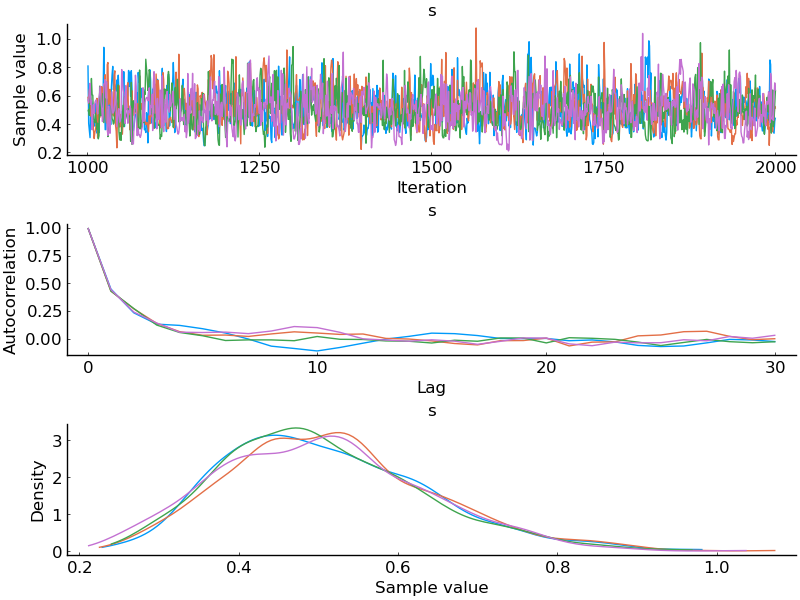

In [127]:
ch = group(chain, :s)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(800,600))

### Posterior Predictive Distribution

The code block below generates the posterior distribution of of response probabilities for each of the six problems. A similar pattern emerges across all six problems: the correct answer is the most likely response at $\approx .8$ and the probability of errors are small and roughly uniform. 


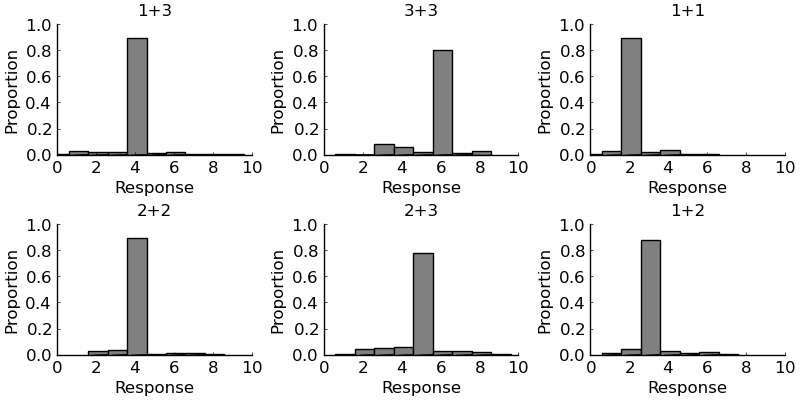

In [128]:
preds = posterior_predictive(x -> simulate(stimuli, parms; x...), chain, 1000)
preds = vcat(vcat(preds...)...)
df = DataFrame(preds)
p5 = response_histogram(df, stimuli; size=(800,400))

# References

Siegler, R. S., & Shrager, J. (1984). Strategy choices in addition and
subtraction: How do children know what to do? In C. Sophian (Ed.),
The origins of cognitive skills (pp. 229-293). Hillsdale, NJ: Erlbaum